# Understanding trends in Agricultural Commodity Pricing

As the title states, our aim is to understand trends in APMC (Agricultural produce market committee)/mandi price & quantity arrival data for different commodities in Maharashtra.

We are supplied with two datasets. One file contains Minimum support price data for 156 different varieties of commodities segmented into 3 varieties of crops i.e. Rabi, Kharif and Other.

The other dataset contains information about various APMCs in the state of Maharashtra along with different commodities and various pricing information(such as max_price, min_price and modal_price)

Our task flow will look like this - 
1. First we'll test and filter the outliers in both the datasets
2. Then we'll understand price fluctuations accounting the seasonal effect 
    1. Detect seasonality type (multiplicative or additive) for each cluster of APMC and commodities
    2. De-seasonalise prices for each commodity and APMC according to the detected seasonality type
3. Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and deseasonalised 
4. Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.     

## Loading relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style='whitegrid')
warnings.filterwarnings('ignore')
pd.set_option('chained_assignment', None)
%matplotlib inline

First, let's test and filter the outliers in the Minimum Support Prices dataset

### Reading and analyzing the Minimum Support Prices dataset

In [2]:
df = pd.read_csv('unfiltered files/CMO_MSP_Mandi.csv') # Loading the Minimum Support Price dataset
df = df.dropna(subset=['msprice']) # Removing all rows with null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 154
Data columns (total 5 columns):
commodity     145 non-null object
year          145 non-null int64
Type          145 non-null object
msprice       145 non-null float64
msp_filter    145 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.8+ KB


So after some minor pre pre-processing, we are left with 145 entries

In [4]:
df.head()

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


##### In order to filter out ouliers we'll begin with Univariate analysis

In [5]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(df['msprice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.84614994]
 [-1.81830924]
 [-1.81134907]
 [-1.8043889 ]
 [-1.8043889 ]
 [-1.28237591]
 [-1.19885383]
 [-1.16405296]
 [-1.14665253]
 [-1.14665253]]

outer range (high) of the distribution:
[[1.58521544]
 [1.68961804]
 [1.68961804]
 [1.75921977]
 [1.86362237]
 [1.86362237]
 [1.89842324]
 [2.09330809]
 [2.17683017]
 [2.37867519]]


Conclusion of Univariate Analysis
* Both the high range and the low range values are close to 0 and are also similar

For now, we may not consider any of these values as outliers.
But let's keep in mind that Univariate Analysis is not conclusive in this case

In [6]:
#skewness and kurtosis
print("Skewness: ", df['msprice'].skew())
print("Kurtosis: ", df['msprice'].kurt())

Skewness:  0.2183673523265302
Kurtosis:  -0.9632063347524178


### Multivariate Analysis

Why do we <b>normalize</b>?

<b>Normality</b> - When we talk about it, what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'msprice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. 

The point here is to test 'msprice' in a very lean way. We'll do this paying attention to:

* <b>Histogram</b> - Kurtosis and skewness.
* <b>Normal probability plot</b> - Data distribution should closely follow the diagonal that represents the normal distribution.

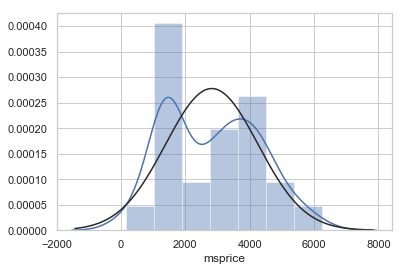

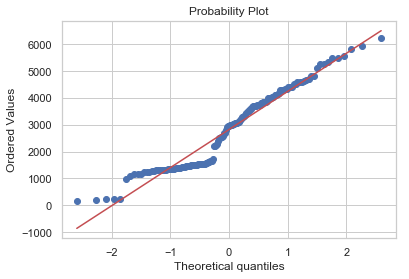

In [7]:
#histogram and normal probability plot
sns.distplot(df['msprice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['msprice'], plot=plt)

#### Since the data is negatively skewed, we can apply square transformation or log tranformation but neither of them seemed to help

## Next Steps..

Since we are unable to find outliers via these methods, let's go back to more traditional statistical methods.
As this blog <a>blog.socialcops.com/academy/resources/find-deal-outliers-data-set</a> from Data Intelligence firm Social Cops explains, 'Using statistical techniques is a more thorough approach to identifying outliers'

So, we are going to create functions that basically find outliers by following this logic - 

In any ordered range of values, there are three quartiles that divide the range into four equal groups. The second quartile (Q2) is nothing but the median, since it divides the ordered range into two equal groups. For an odd number of observations, the median is equal to the middle value of the sorted range.

To calculate the first (Q1) and third quartiles (Q3), you need to simply calculate the medians of the first half and second half respectively.

After that, you need to calculate-
Upper and lower fences which cordon off outliers from the bulk of data in a set. Fences are usually found with the following formulas:

    Upper fence = Q3 + (1.5 * IQR)
    Lower fence = Q1 – (1.5 * IQR)
Where IQR is the interquartile range. 

*Sometimes the value 1.5 is replaced by another value (usually 3), but you’ll usually see 1.5 unless you’re calculating inner and outer fences.

#### Therefore let's create functions that do just that

Functions -

1. Find commodity-price outliers in a particular type of crop and plot them
2. Find outlier according to the msprice range of individual crop type
3. Remove outliers

In [8]:
def find_type_outliers(df): #find outlier according to the msprice range of individual Crop Type
    types=list(df["Type"].unique())
    for typ in types:
        data_temp=df[df["Type"]==typ] # Entire data of one type of crop
        actual=len(data_temp) # Total instances of each crop type
        q1 = data_temp["msprice"].quantile(0.25)
        q3 = data_temp["msprice"].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        lower_threshold  = q1-1.5*iqr
        upper_threshold = q3+1.5*iqr
        data_filter=data_temp[(data_temp["msprice"] > lower_threshold) & (data_temp["msprice"] < upper_threshold)]
        filtered=len(data_filter)
        if actual!=filtered:
            print(typ)
        else:
            print("No outlier found in ",typ)

In [9]:
def plot_commodity_outliers(df): #plot commodity price outliers in a particular type 
    commodities=list(df["commodity"].unique())
    flag=0
    for commodity in commodities:
        data_temp=df[df["commodity"]==commodity] # taking one type of commodity in one iteration
        actual=len(data_temp)
        if actual>1 :
            q1 = data_temp["msprice"].quantile(0.25)
            q3 = data_temp["msprice"].quantile(0.75)
            iqr = q3-q1 #Interquartile range
            lower_threshold  = q1-1.5*iqr
            upper_threshold = q3+1.5*iqr
            data_filter=data_temp[(data_temp["msprice"] > lower_threshold) & (data_temp["msprice"] < upper_threshold)]
            filtered=len(data_filter)
            if actual!=filtered:
                flag=1
                plt.figure(figsize=(6,4))
                plt.title(commodity)
                sns.boxplot(x="commodity", y="msprice",data=data_filter) #box plot
                sns.stripplot(x="commodity", y="msprice",data=data_temp,
                                 jitter=True,marker='o',alpha=0.5,color='red') #overlay data points (show outliers which are not compensated)
                patch_1 = mpatches.Patch(color='#31749F', label=commodity)
                patch_2 = mpatches.Patch(color='red',alpha=0.5,label='Data Points')
                plt.legend(handles=[patch_1,patch_2])
                plt.show()
    if flag==0:
        print("No commodity price outlier in ",df["Type"].iloc[0] )

In [10]:
def remove_outlier_cmo(df): #find outlier according to the msprice of commodity and remove them
    data_main=pd.DataFrame()
    commodities=list(df["commodity"].unique())
    for commodity in commodities:
        data_temp=df[df["commodity"]==commodity]
        actual=len(data_temp)
        if actual>1:
            q1 = data_temp["msprice"].quantile(0.25)
            q3 = data_temp["msprice"].quantile(0.75)
            iqr = q3-q1 #Interquartile range
            lower_threshold  = q1-1.5*iqr
            upper_threshold = q3+1.5*iqr
            data_temp = data_temp.loc[(data_temp['msprice'] > lower_threshold) & (data_temp['msprice'] < upper_threshold)]
            data_temp.sort_values("year",inplace=True)
            
        data_main=pd.concat([data_main,data_temp])
        data_main.reset_index(drop=True,inplace=True)
    return data_main


### Note: We are going to use similar functions to find outliers in our Monthly_data_CMO dataset because of the logic that we have discussed above

### Let's check for outliers using Violin Plots

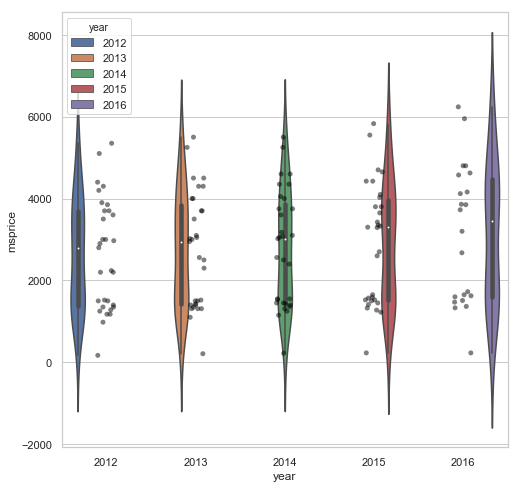

In [11]:
plt.figure(figsize=(8,8))
sns.violinplot(x='year', y='msprice', hue='year', data=df)
sns.stripplot(y='msprice', x='year',data=df,jitter=True,marker='o',alpha=0.5,color='black') #overlay data point
plt.show()

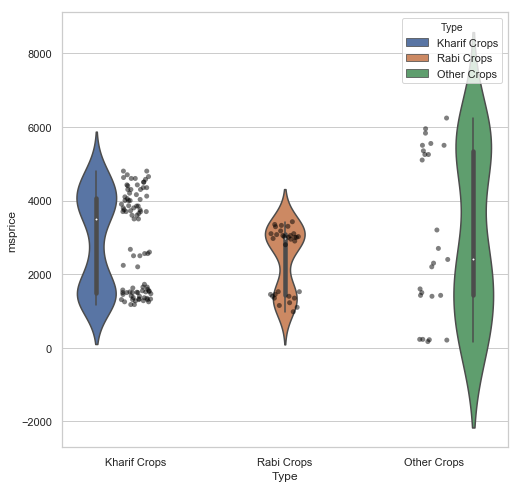

In [12]:
plt.figure(figsize=(8,8))
sns.violinplot(x='Type', y='msprice', hue='Type', data=df)
sns.stripplot(y='msprice', x='Type',data=df,jitter=True,marker='o',alpha=0.5,color='black') #overlay data point
plt.show()

### We can further compare each commodity to its crop type

#### Kharif Crops

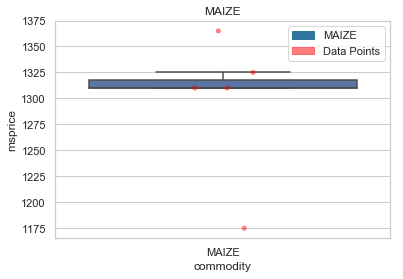

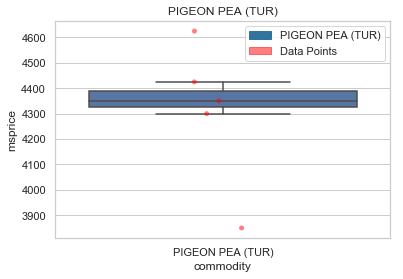

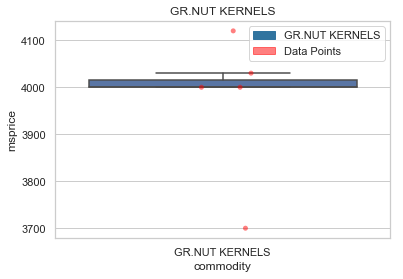

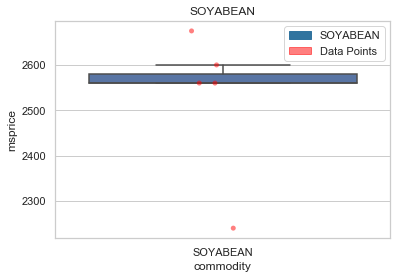

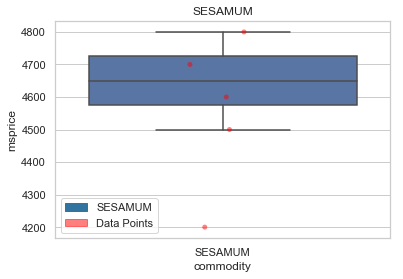

In [13]:
plot_commodity_outliers(df[df['Type']=='Kharif Crops'])

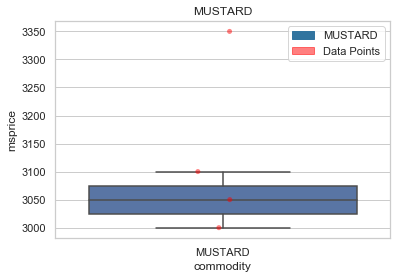

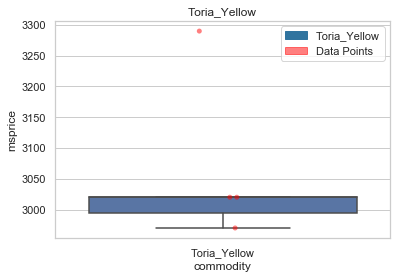

In [14]:
plot_commodity_outliers(df[df['Type']=='Rabi Crops'])

In [15]:
plot_commodity_outliers(df[df['Type']=='Other Crops'])

No commodity price outlier in  Other Crops


### Now let's call the Remove Outlier function to do just that

In [16]:
data = remove_outlier_cmo(df)
data.to_csv('filtered_msp.csv', index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 5 columns):
commodity     134 non-null object
year          134 non-null int64
Type          134 non-null object
msprice       134 non-null float64
msp_filter    134 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.3+ KB



##### As we can observe, we have 134 values remaining in our dataset from the 145 that we got after pre-processing. Therefore, we have successfully removed outliers and stored the Filtere dataset in a new file

### Reading and Analyzing the Monthly Data dataset

In [17]:
df = pd.read_csv("unfiltered files/Monthly_data_cmo.csv")
df["Commodity"] = df["Commodity"].apply( lambda x : x.lower()) # Converting all Commodity names to Lowercase to establish uniformity and avoid confusion
df = df[df["modal_price"]!=0] 
df["date"] = pd.to_datetime(df["date"]) # Converting dataframe to a DateTime dataset in order to perform Time Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62225 entries, 0 to 62428
Data columns (total 11 columns):
APMC               62225 non-null object
Commodity          62225 non-null object
Year               62225 non-null int64
Month              62225 non-null object
arrivals_in_qtl    62225 non-null int64
min_price          62225 non-null int64
max_price          62225 non-null int64
modal_price        62225 non-null int64
date               62225 non-null datetime64[ns]
district_name      62225 non-null object
state_name         62225 non-null object
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 5.7+ MB


In [19]:
df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,bajri,2015,April,79,1406,1538,1463,2015-04-01,Ahmadnagar,Maharashtra
1,Ahmednagar,bajri,2016,April,106,1788,1925,1875,2016-04-01,Ahmadnagar,Maharashtra
2,Ahmednagar,wheat(husked),2015,April,1253,1572,1890,1731,2015-04-01,Ahmadnagar,Maharashtra
3,Ahmednagar,wheat(husked),2016,April,387,1750,2220,1999,2016-04-01,Ahmadnagar,Maharashtra
4,Ahmednagar,sorgum(jawar),2015,April,3825,1600,2200,1900,2015-04-01,Ahmadnagar,Maharashtra


##### Let's count the occurcence of each unique district and APMC

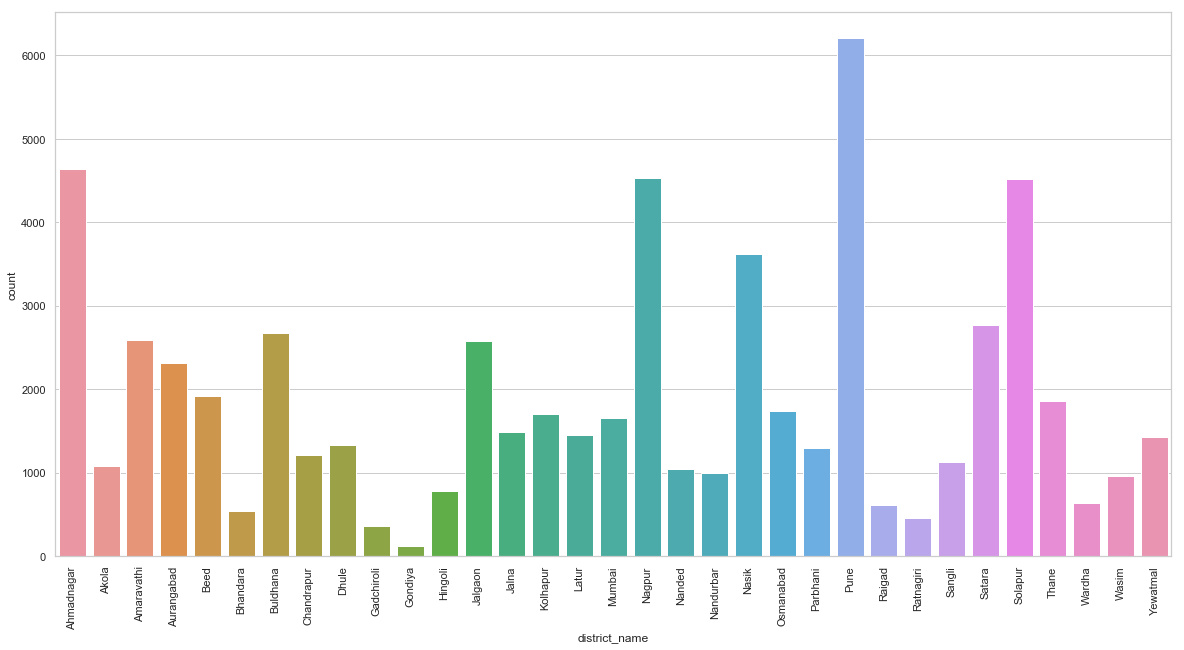

In [20]:
# Counting the occurences of each district
n = df['district_name'].value_counts()
#print ('There are', n ,'districts')
plt.figure(figsize=(20,10))
sns.countplot(df['district_name'])
plt.xticks(rotation=90)
plt.show()

#### It's not really relevant to count the number of districts as observing the data reveals that many different APMC's lie under the same district, so we'll focus only on APMC's from now on.

In [21]:
df['APMC'].unique()

array(['Ahmednagar', 'Akole', 'Jamkhed', 'Kopargaon', 'Newasa',
       'Newasa-Ghodegaon', 'Parner', 'Pathardi', 'Rahata', 'Rahuri',
       'Rahuri-Vambori', 'Sangamner', 'Shevgaon', 'Shevgaon-Bodhegaon',
       'Shrirampur', 'Shrirampur-Belapur', 'Shrigonda',
       'Shrigonda-Ghogargaon', 'Karjat (A- Nagar)', 'Rahuri-Songaon',
       'Akola', 'Akot', 'Balapur', 'Murtizapur', 'Patur', 'Telhara',
       'Barshi Takli', 'Achalpur', 'Amarawati',
       'Amarawati-Fruit And Vegetables', 'Anajngaon Surji',
       'Chandur Bajar', 'Chandur Rly.', 'Daryapur', 'Dhamangaon-Rly',
       'Dharni', 'Morshi', 'Nandgaon Khandeshwar', 'Varud',
       'Varud-Rajura Bazar', 'Tiwasa', 'Aurangabad', 'Fulambri',
       'Gangapur', 'Kannad', 'Lasur Station', 'Paithan', 'Sillod',
       'Sillod-Bharadi', 'Soygaon', 'Vaijapur', 'Khultabad', 'Ambejogai',
       'Beed', 'Gevrai', 'Kada', 'Kada (Ashti)', 'Kej', 'Kille Dharur',
       'Majalgaon', 'Parli-Vaijnath', 'Bhandara', 'Lakhandur', 'Lakhani',
       'Pa

In [22]:
df['APMC'].nunique()

349

#### So there are 349 distinct APMCs

Now, as we did with the other dataset, let's create functions to filter and plot out outliers

In [23]:
# Same as the function defined earlier but with minor tweaks corresponding to new dataset

def plot_price_outliers(df): #plot commodity price outliers in a particular type 
    commodities=list(df["Commodity"].unique())
    flag=0
    for commodity in commodities:
        data_temp=df[df["Commodity"]==commodity] # taking one type of commodity in one iteration
        actual=len(data_temp)
        if actual>1 :
            q1 = data_temp["modal_price"].quantile(0.25)
            q3 = data_temp["modal_price"].quantile(0.75)
            iqr = q3-q1 #Interquartile range
            lower_threshold  = q1-1.5*iqr
            upper_threshold = q3+1.5*iqr
            data_filter=data_temp[(data_temp["modal_price"] > lower_threshold) & (data_temp["modal_price"] < upper_threshold)]
            filtered=len(data_filter)
            if actual!=filtered:
                flag=1
                plt.figure(figsize=(6,4))
                plt.title(commodity)
                sns.boxplot(x="Commodity", y="modal_price",data=data_filter) #box plot
                sns.stripplot(x="Commodity", y="modal_price",data=data_temp,
                                 jitter=True,marker='o',alpha=0.5,color='red') #overlay data points (show outliers which are not compensated)
                patch_1 = mpatches.Patch(color='#31749F', label=commodity)
                patch_2 = mpatches.Patch(color='red',alpha=0.5,label='Data Points')
                plt.legend(handles=[patch_1,patch_2])
                plt.show()
    if flag==0:
        print("No modal price outliers found" )

In [24]:
def remove_outlier(df): #find outlier according to the modal price of commodity and remove them
    data_main=pd.DataFrame()
    commodities=list(df["Commodity"].unique())
    for commodity in commodities:
        data_temp=df[df["Commodity"]==commodity]
        actual=len(data_temp)
        if actual>1:
            q1 = data_temp["modal_price"].quantile(0.25)
            q3 = data_temp["modal_price"].quantile(0.75)
            iqr = q3-q1 #Interquartile range
            lower_threshold  = q1-1.5*iqr
            upper_threshold = q3+1.5*iqr
            filtered_values=[upper_threshold if x> upper_threshold else x for x in data_temp["modal_price"].tolist()]
            filtered_values=[lower_threshold if x< lower_threshold else x for x in filtered_values]
            data_temp["modal_price"]=filtered_values
            data_temp.sort_values("date",inplace=True)
            
        data_main=pd.concat([data_main,data_temp])
        data_main.reset_index(drop=True,inplace=True)
    return data_main

Enter APMC: Barshi
Enter Commodity within that APMC: brinjal


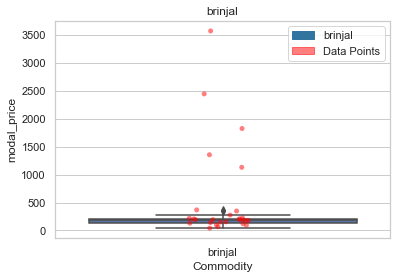

In [25]:
apmc = input('Enter APMC: ')
comm = input('Enter Commodity within that APMC: ')

df_temp = df[df['APMC'] == apmc]
df_temp = df_temp[df['Commodity'] == comm]

plot_price_outliers(df_temp)

#### Let's remove the outliers and save the filtered dataset

In [26]:
df_filtered=pd.DataFrame()
for apmc in df["APMC"].unique().tolist():
    df_temp=df[df["APMC"]==apmc]
    data=remove_outlier(df_temp)
    df_filtered=pd.concat([df_filtered,data])

In [27]:
df_filtered.shape

(62225, 11)

In [28]:
df_filtered.reset_index(drop=True,inplace=True)
df_filtered.to_csv("Monthly_data_cmo_filtered.csv",index=False)

## Now that we are done with detecting outliers, its time to work out the price fluctuations accounting the seasonal effect

In [29]:
df=pd.read_csv("Monthly_data_cmo_filtered.csv")
df["date"]=pd.to_datetime(df["date"])
df["quarter"]=df["date"].dt.quarter
df["combination_label"]=df["APMC"]+":"+df["Commodity"]
df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,quarter,combination_label
0,Ahmednagar,bajri,2014,September,24,1400,1750,1575.0,2014-09-01,Ahmadnagar,Maharashtra,3,Ahmednagar:bajri
1,Ahmednagar,bajri,2014,November,395,1507,1750,1629.0,2014-11-01,Ahmadnagar,Maharashtra,4,Ahmednagar:bajri
2,Ahmednagar,bajri,2015,January,97,1472,1764,1618.0,2015-01-01,Ahmadnagar,Maharashtra,1,Ahmednagar:bajri
3,Ahmednagar,bajri,2015,February,10,1500,1800,1650.0,2015-02-01,Ahmadnagar,Maharashtra,1,Ahmednagar:bajri
4,Ahmednagar,bajri,2015,March,14,1350,1700,1525.0,2015-03-01,Ahmadnagar,Maharashtra,1,Ahmednagar:bajri


### We have a created a new column called 'combination_label' by grouping 'APMC' and 'Commodity'

In [30]:
# Grouping based on APMC, comm, year and taking count to remove those clusters with count<12
def group(df):
    data=df[["APMC","Commodity","modal_price","Year","combination_label"]].groupby(["APMC","Commodity","Year",
            "combination_label"],as_index=False).count().rename(columns={"modal_price":"Count"}).reset_index(drop=True)
    return data

Selecting only those APMC Commodities (cluster) which have data points for atleast a complete year (time series analysis

In [31]:
data = group(df)
data = data[data['Count']==12].reset_index(drop=True)
data.head(15)

,APMC,Commodity,Year,combination_label,Count
0,Aamgaon,paddy-unhusked,2015,Aamgaon:paddy-unhusked,12
1,Akhadabalapur,soybean,2015,Akhadabalapur:soybean,12
2,Akluj,bitter gourd,2015,Akluj:bitter gourd,12
3,Akluj,brinjal,2015,Akluj:brinjal,12
4,Akluj,cabbage,2015,Akluj:cabbage,12
5,Akluj,chikoo,2015,Akluj:chikoo,12
6,Akluj,chillies(red),2015,Akluj:chillies(red),12
7,Akluj,garlic,2015,Akluj:garlic,12
8,Akluj,ladies finger,2015,Akluj:ladies finger,12
9,Akluj,maize,2015,Akluj:maize,12


In [32]:
filtered=data["combination_label"].unique().tolist()
df_filtered=df[df["combination_label"].isin(filtered)].reset_index(drop=True)

In [33]:
# Data ready to use
df_filtered.to_csv("filtered_data_for_seasonality_analysis.csv",index=False)

### We are going to use a pre-created function and 'seasonal_decmpose' from statsmodels to detect seasonality 

In [34]:
# A function that checks the seasonality type and deseasonalizes the prices if passed 'True' as a second parameter

def check_seasonality_type(data_filter, deseasonalize = False):
    data_filter['Period'] = data_filter["Year"].astype(str) + data_filter["Month"]
    data_filter['Period'] = pd.to_datetime(data_filter['Period'], format="%Y%B")
    
    # Temp dataframe to perform decomposition on
    ts_df = pd.DataFrame(data=data_filter['modal_price'].values, index=data_filter['Period'], columns=['modal_price'])
    ts_df.index = pd.to_datetime(ts_df.index)
    
    # Dealing with missing values:
    # 1. Resampling: parameter 'MS' stands for Month start.
    # 2. Filling resampled NaN values with average price of that commodity over time
    ts_df = ts_df.resample('MS').mean()
    ts_df = ts_df.fillna(int(ts_df['modal_price'].mean()))
    
    
    
   
    # Decomposing data 
    resultadd = seasonal_decompose(ts_df, model='additive',freq=12)
    resultmult = seasonal_decompose(ts_df, model='multiplicative',freq=12)
        
    try:
        # Auto correlation function returns a value that determines which seasonality type fits the data better
        additive_acf=sum(np.asarray(acf(resultadd.resid, missing='drop'))*2)
        multiplicative_acf=sum(np.asarray(acf(resultmult.resid, missing='drop'))*2)
        
    except:
        # reducing freq if insufficient data points
        resultadd = seasonal_decompose(ts_df, model='additive',freq=6)
        resultmult = seasonal_decompose(ts_df, model='multiplicative',freq=6)
    
        # Auto correlation function returns a value that determines which seasonality type fits the data better
        additive_acf=sum(np.asarray(acf(resultadd.resid, missing='drop'))*2)
        multiplicative_acf=sum(np.asarray(acf(resultmult.resid, missing='drop'))*2)
    

    if additive_acf<multiplicative_acf:
        value = "Additive" # Additive seasonality confirmed
        if deseasonalize:
            # Removing seasonality
            ts_df['Seasonal'] = resultadd.seasonal.values
            
            # Removing seasonality component from additive data
            values=ts_df["modal_price"]-ts_df['Seasonal']
            values=values.tolist()
            
            indexes=data_filter.index.tolist()
            values_range=range(0,len(values))
            for index,value in zip(indexes,values_range):
                data_filter.at[index,"deseasonalise_price"]=values[value]
            
            return data_filter[["APMC","Commodity","combination_label","date","modal_price","quarter","deseasonalise_price"]]
            
        else:
            return "Additive"
        
    else:
        value = "Multiplicative" # Multiplicative seasonality confirmed
        if deseasonalize:
            # Removing seasonality
            ts_df['Seasonal'] = resultmult.seasonal.values
            
            # Removing seasonality component from multiplicative data
            values=ts_df["modal_price"]/ts_df['Seasonal']
            values=values.tolist()
            
            indexes=data_filter.index.tolist()
            values_range=range(0,len(values))
            for index,value in zip(indexes,values_range):
                data_filter.at[index,"deseasonalise_price"]=values[value]
            
            return data_filter[["APMC","Commodity","combination_label","date","modal_price","quarter","deseasonalise_price"]]
        
        else:
            return "Multiplicative"
 

In [35]:
df=pd.read_csv("filtered_data_for_seasonality_analysis.csv")
df["date"]=pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25027 entries, 0 to 25026
Data columns (total 13 columns):
APMC                 25027 non-null object
Commodity            25027 non-null object
Year                 25027 non-null int64
Month                25027 non-null object
arrivals_in_qtl      25027 non-null int64
min_price            25027 non-null int64
max_price            25027 non-null int64
modal_price          25027 non-null float64
date                 25027 non-null datetime64[ns]
district_name        25027 non-null object
state_name           25027 non-null object
quarter              25027 non-null int64
combination_label    25027 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(6)
memory usage: 2.5+ MB


In [36]:
commodities=list(df["combination_label"].unique())
seasonality_type=[]

# commodity here stands for combination of APMC and commodity
for commodity in commodities:
    data_filter=df[df["combination_label"]==commodity]
    seasonality_type.append((commodity,check_seasonality_type(data_filter)))

In [37]:
# Storing Seasonality types 

dataframe=pd.DataFrame(seasonality_type,columns=["Commodity","Seasonality Type"])
dataframe.to_csv("seasonality_type.csv",index=False)

In [38]:
dataframe[1:25]

,Commodity,Seasonality Type
1,Akole:paddy-unhusked,Additive
2,Akole:wheat(husked),Multiplicative
3,Akole:gram,Multiplicative
4,Akole:soybean,Multiplicative
5,Akole:onion,Multiplicative
6,Jamkhed:bajri,Multiplicative
7,Jamkhed:wheat(husked),Additive
8,Jamkhed:sorgum(jawar),Multiplicative
9,Jamkhed:onion,Additive
10,Kopargaon:bajri,Additive


In [39]:
# Loading both files to deseasonalize prices

df_type=pd.read_csv("seasonality_type.csv").set_index("Commodity").to_dict()["Seasonality Type"]
df_data=pd.read_csv("filtered_data_for_seasonality_analysis.csv")

#initialize empty column
df_data["deseasonalise_price"]=np.nan 

In [40]:
commoditites=list(df_type.keys())
data_main=pd.DataFrame() #new data frame 

# commodity here stands for combination of APMC and commodity
for commodity in commoditites:
    data_temp=check_seasonality_type(df_data[df_data["combination_label"]==commodity],deseasonalize = True)
    data_main=pd.concat([data_main,data_temp])

In [41]:
# Storing deseasonalzied prices
data_main.to_csv("deseasonalize.csv",index=False)

In [42]:
pd.read_csv("deseasonalize.csv")

,APMC,Commodity,combination_label,date,modal_price,quarter,deseasonalise_price
0,Akole,bajri,Akole:bajri,2014-09-01,1650.00,3,1664.590398
1,Akole,bajri,Akole:bajri,2014-10-01,1560.00,4,1588.085197
2,Akole,bajri,Akole:bajri,2014-11-01,1550.00,4,1572.191403
3,Akole,bajri,Akole:bajri,2014-12-01,1563.00,4,1536.385799
4,Akole,bajri,Akole:bajri,2015-01-01,1580.00,1,1607.065791
5,Akole,bajri,Akole:bajri,2015-02-01,1470.75,1,1506.609180
6,Akole,bajri,Akole:bajri,2015-03-01,1538.00,1,1558.935506
7,Akole,bajri,Akole:bajri,2015-04-01,1525.00,2,1511.581534
8,Akole,bajri,Akole:bajri,2015-05-01,1712.75,2,1604.507256
9,Akole,bajri,Akole:bajri,2015-06-01,1588.00,2,1563.664803


### Having deseasonalized the prices, it's time to compare prices in APMC/Mandi with Minimum Support Price - raw and deseasonlized

In [43]:
df=pd.read_csv("deseasonalize.csv")
df["date"]=pd.to_datetime(df["date"])
comm = df['Commodity'].unique().tolist()

df_msp = pd.read_csv("filtered_msp.csv")
df_msp['commodity'] = df_msp['commodity'].str.lower()
commodities = df_msp['commodity'].unique().tolist()

# Removing 2012, 2013s data as we don't have modal prices for those years
df_msp = df_msp[df_msp['year'] != 2012]
df_msp = df_msp[df_msp['year'] != 2013]
df_msp["year"]=pd.to_datetime(df_msp["year"], format= '%Y')
df.head()

,APMC,Commodity,combination_label,date,modal_price,quarter,deseasonalise_price
0,Akole,bajri,Akole:bajri,2014-09-01,1650.0,3,1664.590398
1,Akole,bajri,Akole:bajri,2014-10-01,1560.0,4,1588.085197
2,Akole,bajri,Akole:bajri,2014-11-01,1550.0,4,1572.191403
3,Akole,bajri,Akole:bajri,2014-12-01,1563.0,4,1536.385799
4,Akole,bajri,Akole:bajri,2015-01-01,1580.0,1,1607.065791


In [44]:
# Function which compares prices and prints a comparison plot
def compare_price(apmc, commodity):
    
    label = str(apmc)+':'+str(commodity)
    data_filter = df[df["combination_label"]==label]
    
    # If no such match found within our data due to:
    # 1. Insufficient MSP data
    # 2. Invalid apmc,commodity cluster
    # 3. Apmc, commodity group which has already been filtered out during pre processing
    if data_filter.shape[0] == 0: 
        return "Not enough data"
    
    msp = df_msp[df_msp['commodity'] == 'bajri']
    msp = msp[['year', 'msprice']]
    
    # Plotting (Dates on X axis)
    xaxis = pd.to_datetime(data_filter['date'])
    plt.figure(figsize=(9, 7))
    plt.plot(data_filter['date'], data_filter['modal_price'])
    plt.plot(data_filter['date'], data_filter['deseasonalise_price'])
    plt.plot(msp['year'], msp['msprice'], color = 'y')
    #plt.plot(data_filter[])
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(rotation=45)
    plt.legend(['Actual price', 'Deseasonalized', 'MSP'])
    plt.show()

Enter APMC: Barshi
Enter Commodity within that APMC: brinjal


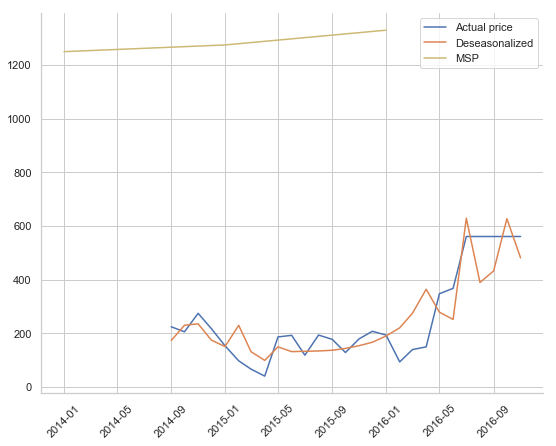

In [45]:
# Enter the cluster of APMC, Commodity you want to compare
apmc = input('Enter APMC: ')
comm = input('Enter Commodity within that APMC: ')

compare_price(apmc, comm)

## Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.

In [46]:
def highest_price_fluctuation_commodities(df): #return name of commodities with highest price (max_price) fluctuation in each APMC
    data=[]
    commodities=df["combination_label"].unique().tolist()
    for commodity in commodities:
        df_temp=df[df["combination_label"]==commodity]
        value=stats.variation(df_temp["max_price"]) # variation coeff = mean/(std deviation)
        data.append((commodity,value))
        
    data.sort(key=lambda x: x[1],reverse= True)
    data=[x[0] for x in data[:20]] #top 20 APMC commodities cluster name
    return data

In [47]:
df=pd.read_csv("filtered_data_for_seasonality_analysis.csv")
df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,quarter,combination_label
0,Akole,bajri,2014,September,25,1467,1733,1650.0,2014-09-01,Ahmadnagar,Maharashtra,3,Akole:bajri
1,Akole,bajri,2014,October,30,1390,1700,1560.0,2014-10-01,Ahmadnagar,Maharashtra,4,Akole:bajri
2,Akole,bajri,2014,November,67,1400,1700,1550.0,2014-11-01,Ahmadnagar,Maharashtra,4,Akole:bajri
3,Akole,bajri,2014,December,40,1375,1750,1563.0,2014-12-01,Ahmadnagar,Maharashtra,4,Akole:bajri
4,Akole,bajri,2015,January,74,1395,1840,1580.0,2015-01-01,Ahmadnagar,Maharashtra,1,Akole:bajri


In [48]:
fluctuation=highest_price_fluctuation_commodities(df)
fluctuation

['Barshi:brinjal',
 'Barshi:tomato',
 'Barshi:cabbage',
 'Barshi:green chilli',
 'Barshi:flower',
 'Barshi:lemon',
 'Barshi:cluster bean',
 'Barshi:cucumber',
 'Barshi:ladies finger',
 'Barshi:capsicum',
 'Barshi:bitter gourd',
 'Pune:squash gourd',
 'Vadgaon Peth:tomato',
 'Mumbai:squash gourd',
 'Aurangabad:tomato',
 'Kalvan:onion',
 'Yeola:onion',
 'Shahada:maize',
 'Pune-Pimpri:onion',
 'Solapur:papai']

In [49]:
data_main.to_csv("price_fluctuation.csv",index=False)

#### APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.

In [50]:
data_main=pd.DataFrame()
for commodity in fluctuation:
    
    # Setting the bar high with a range of upto 3 SD above the mean
    value=df[df["combination_label"]==commodity]["max_price"].std()*3
    
    # If a APMC/Commodity value for any month/year crosses 3 SDs i.e 99 percentile, then that has high price fluctuation
    df_temp=df[(df["combination_label"]==commodity)&(df["max_price"]>value)]
    df_temp=df_temp[["APMC","Commodity","Month","Year","max_price"]]
    data_main=pd.concat([data_main,df_temp])
data_main.reset_index(drop=True)

,APMC,Commodity,Month,Year,max_price
0,Barshi,brinjal,October,2016,4163
1,Barshi,tomato,July,2016,2445
2,Barshi,cabbage,July,2016,1486
3,Barshi,green chilli,July,2016,5190
4,Barshi,flower,July,2016,1641
5,Barshi,flower,October,2016,1447
6,Barshi,lemon,September,2016,4647
7,Barshi,cluster bean,October,2016,4821
8,Barshi,cucumber,October,2016,1590
9,Barshi,ladies finger,July,2016,2105


In [51]:
data_main.to_csv("flagged_prices.csv",index=False)